In [1]:
from skimage import transform
import datetime
import numpy as np
import cv2
from PIL import Image
import math
import os
import json
from tqdm import tqdm
import matplotlib.pyplot as plt

## Additonal filtering using yolov3 on WIDER FACE

In [2]:
def get_outputs_names(net):
    layers_names = net.getLayerNames()
    return [layers_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

def post_process(frame, outs, conf_threshold, nms_threshold):
    frame_height = frame.shape[0]
    frame_width = frame.shape[1]
    confidences = []
    boxes = []
    last_box=[]
    people_boxes = []
    center = []
    class_ids = []
    if True:

        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if confidence > conf_threshold:
                    center_x = int(detection[0] * frame_width)
                    center_y = int(detection[1] * frame_height)
                    width = int(detection[2] * frame_width)
                    height = int(detection[3] * frame_height)
                    left = int(center_x - width / 2)
                    top = int(center_y - height / 2)
                    confidences.append(float(confidence))
                    boxes.append([left, top, width, height])
                    center.append([center_x, center_y])
                    class_ids.append(class_id)

    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold,
                               nms_threshold)
    
    counter = 0
    for i in indices:
        i = i[0]
        if class_ids[i]==0:
            counter+=1
    return counter==1

In [3]:
CONF_THRESHOLD = 0.9
NMS_THRESHOLD = 0.9
IMG_WIDTH = 416
IMG_HEIGHT = 416
model_cfg = 'cfg/yolov3-face.cfg'
model_weights = 'weights/yolov3-wider_16000.weights'
annotations_path = "../data/new_annotations/annot.json"
image_dir = "../data/train2014/"
images_list = os.listdir(image_dir)

In [4]:
annotations = json.load(open(annotations_path,'r'))

In [5]:
net = cv2.dnn.readNetFromDarknet(model_cfg, model_weights)

net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [6]:
new_annotations = {}
for i in tqdm(annotations.keys()):
    frame = cv2.imread(image_dir + '/' + i)
    img = Image.open(image_dir + '/' + i)
    width, height = img.size
    blob = cv2.dnn.blobFromImage(frame, 1 / 255, (IMG_WIDTH, IMG_HEIGHT),
                                [0, 0, 0], 1, crop=False)
    net.setInput(blob)


    outs = net.forward(get_outputs_names(net))

    if post_process(frame, outs, CONF_THRESHOLD, NMS_THRESHOLD
                                       ):
        new_annotations.update({i:annotations[i]})
        
print('Before filtering : {}'.format(len(annotations)))
print('After filtering : {}'.format(len(new_annotations)))

100%|██████████| 29766/29766 [2:38:15<00:00,  3.13it/s]  

Before filtering : 29766
After filtering : 3173


## New annotations visualization

['a person standing next to a parked large truck']


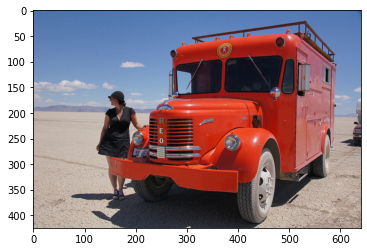

In [83]:
idx = np.random.choice(range(len(new_annotations)))
path, labels = list(new_annotations.items())[idx]
image = np.array(Image.open(os.path.join(image_dir,path)))
plt.imshow(image);
print(labels)

## Saving final annotations

In [8]:
if not os.path.exists('../data/new_annotations'):
    os.mkdir('../data/new_annotations')
with open('../data/new_annotations/final_annot_coco.json', 'w') as f:
    json.dump(new_annotations,f)